## Connecting to drive



In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Copying Data/Models

In [ ]:
!mkdir data
!mkdir models

!cp '/gdrive/My Drive/Semester 8/CV/snek/datasets/train_small_10_cropped.tar.gz' ./data

!tar -xvf ./data/train_small_10_cropped.tar.gz -C ./data/

## Imports

In [ ]:
import os
import copy
import torch
import random
import pickle
import argparse
import torchvision
import numpy as np
import torch.nn as nn

import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.checkpoint as cp

from PIL import Image
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
MODEL_DIR = "./models"
DATASET_PATH = "./data/data/train_cropped/"

## Model and Dataset Definition

In [ ]:
def load_dataset(root,
                 batchsize,
                 input_size,
                 crop_size,
                 validation_split=.2,
                 shuffle_dataset=True,
                 random_seed=42,
                 num_workers=2):

    data_path = root
    trainTransform  = torchvision.transforms.Compose([torchvision.transforms.Resize((input_size, input_size)),
                        torchvision.transforms.CenterCrop(crop_size),
                        torchvision.transforms.ToTensor(),
                        transforms.Normalize([0.0432, 0.0554, 0.0264], [0.8338, 0.8123, 0.7803]),
                        ])

    dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=trainTransform
    )

    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset,
                                               batch_size=batchsize,
                                               sampler=train_sampler,
                                               num_workers=num_workers)

    valid_loader = torch.utils.data.DataLoader(dataset,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=num_workers)

    return train_loader, valid_loader
    # train_loader = torch.utils.data.DataLoader(
    #     train_dataset,
    #     batch_size=batchsize,
    #     num_workers=2,
    #     shuffle=True
    # )
    # return train_loader, train_dataset

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
	if feature_extracting:
		for param in model.parameters():
			param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet":  # ResNet-50
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        crop_size = 224

    elif model_name == "vgg":  # VGG-11
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        crop_size = 224

    elif model_name == "densenet":  # DenseNet-121
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        crop_size = 224
    
    elif model_name == "inception":
        model_ft = models.inception_v3(pretrained=use_pretrained, aux_logits=False)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 299
        crop_size = 299
    
    elif model_name == "resnext":
        model_ft = models.resnext50_32x4d(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        crop_size = 224

    return model_ft, input_size, crop_size

## Constants

In [ ]:
num_epochs = 20
batch_size = 16
model_name = "densenet"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Using device: {}".format(device))

Using device: cuda:0


## Loading Data and Model

In [ ]:
data = datasets.ImageFolder(DATASET_PATH)
num_classes = len(data.classes)

print("Number of classes: {}".format(num_classes))

Number of classes: 10


In [ ]:
model_ft, input_size, crop_size = initialize_model(model_name,
                                                   num_classes,
                                                   feature_extract=True,
                                                   use_pretrained=True)

train_loader, valid_loader = load_dataset(DATASET_PATH, batch_size, input_size, crop_size)

dataloaders_dict = {
    "train": train_loader,
    "valid": valid_loader
}

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [ ]:
# model_weights = torch.load(model_dir, map_location=device)
# model_ft.load_state_dict(model_weights)
# print('Loaded model', model_dir)

In [ ]:
model_ft = model_ft.to(device)

In [ ]:
# Optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr=3e-4)

# Loss Funciton
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, model_name, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_fscore = 0.0
    
    loss_train_evo=[]
    acc_train_evo=[]
    fs_train_evo=[]
    
    loss_val_evo=[]
    acc_val_evo=[]
    fs_val_evo=[]
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            fscore = []

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # inputs, labels = inputs.cuda(), labels.cuda()
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                labels_cpu = labels.cpu().numpy()
                predictions_cpu = preds.cpu().numpy()
                Fscore = f1_score(labels_cpu, predictions_cpu, average='macro')
                fscore.append(Fscore)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / (len(dataloaders[phase]) * batch_size)
            epoch_acc = running_corrects.double() / (len(dataloaders[phase]) * batch_size)
            epoch_fscore = np.average(np.array(fscore))
            
            print('{} Loss: {:.4f} Acc: {:.4f} F: {:.3f}'.format(phase, epoch_loss, epoch_acc, epoch_fscore))

            MODEL_PATH = os.path.join(MODEL_DIR, model_name + "_model_{}.pt".format(epoch))
            OPTIM_PATH = os.path.join(MODEL_DIR, model_name + "_optim_{}.pt".format(epoch))
            torch.save(model.state_dict(), MODEL_PATH)
            torch.save(optimizer.state_dict(), OPTIM_PATH)
            
            if phase == 'train':
                loss_train_evo.append(epoch_loss)
                epoch_acc = epoch_acc.cpu().numpy()
                acc_train_evo.append(epoch_acc)
                fs_train_evo.append(epoch_fscore)                
            else:
                loss_val_evo.append(epoch_loss)
                epoch_acc = epoch_acc.cpu().numpy()
                acc_val_evo.append(epoch_acc)
                fs_val_evo.append(epoch_fscore) 
                
            if phase == 'valid' and epoch_fscore > best_fscore:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, loss_train_evo, acc_train_evo, fs_train_evo, loss_val_evo, acc_val_evo, fs_val_evo

In [ ]:
model_ft, loss_train, acc_train, fs_train, loss_val, acc_val, fs_val = train_model(model_ft,
                                                                                   dataloaders_dict,
                                                                                   criterion,
                                                                                   optimizer_ft,
                                                                                   model_name,
                                                                                   num_epochs=num_epochs)

Epoch 1/20



train Loss: 1.4870 Acc: 0.5084 F: 0.405



valid Loss: 1.1164 Acc: 0.6469 F: 0.536
Epoch 2/20



train Loss: 1.0701 Acc: 0.6457 F: 0.558



valid Loss: 0.9437 Acc: 0.6852 F: 0.582
Epoch 3/20



train Loss: 0.9638 Acc: 0.6721 F: 0.584



valid Loss: 0.8851 Acc: 0.6991 F: 0.600
Epoch 4/20



train Loss: 0.9180 Acc: 0.6842 F: 0.599



valid Loss: 0.8595 Acc: 0.7015 F: 0.603
Epoch 5/20



train Loss: 0.8761 Acc: 0.6980 F: 0.607



valid Loss: 0.8241 Acc: 0.7118 F: 0.612
Epoch 6/20



train Loss: 0.8528 Acc: 0.7042 F: 0.621



valid Loss: 0.8056 Acc: 0.7168 F: 0.613
Epoch 7/20



train Loss: 0.8375 Acc: 0.7110 F: 0.632



valid Loss: 0.8265 Acc: 0.7038 F: 0.615
Epoch 8/20



train Loss: 0.8177 Acc: 0.7148 F: 0.634



valid Loss: 0.7918 Acc: 0.7174 F: 0.622
Epoch 9/20



train Loss: 0.8096 Acc: 0.7156 F: 0.633



valid Loss: 0.8066 Acc: 0.7038 F: 0.616
Epoch 10/20



train Loss: 0.8003 Acc: 0.7171 F: 0.636



valid Loss: 0.7859 Acc: 0.7214 F: 0.637
Epoch 11/20



train Loss: 0.7809 Acc: 0.7260 F: 0.643



valid Loss: 0.8023 Acc: 0.7131 F: 0.619
Epoch 12/20



train Loss: 0.7856 Acc: 0.7230 F: 0.638



valid Loss: 0.7822 Acc: 0.7201 F: 0.624
Epoch 13/20



train Loss: 0.7783 Acc: 0.7271 F: 0.648



valid Loss: 0.8319 Acc: 0.7025 F: 0.612
Epoch 14/20



train Loss: 0.7660 Acc: 0.7306 F: 0.651



valid Loss: 0.7865 Acc: 0.7144 F: 0.614
Epoch 15/20



train Loss: 0.7732 Acc: 0.7212 F: 0.636



valid Loss: 0.7720 Acc: 0.7224 F: 0.629
Epoch 16/20



train Loss: 0.7564 Acc: 0.7312 F: 0.653



valid Loss: 0.7738 Acc: 0.7287 F: 0.641
Epoch 17/20



train Loss: 0.7520 Acc: 0.7292 F: 0.651



valid Loss: 0.7647 Acc: 0.7277 F: 0.637
Epoch 18/20



train Loss: 0.7504 Acc: 0.7338 F: 0.653



valid Loss: 0.7758 Acc: 0.7164 F: 0.627
Epoch 19/20



train Loss: 0.7540 Acc: 0.7331 F: 0.657



valid Loss: 0.7931 Acc: 0.7168 F: 0.629
Epoch 20/20



train Loss: 0.7481 Acc: 0.7340 F: 0.651



valid Loss: 0.7723 Acc: 0.7264 F: 0.638


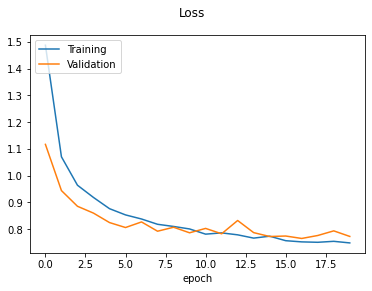

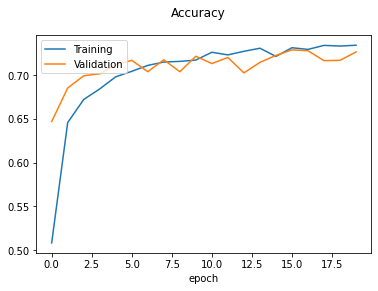

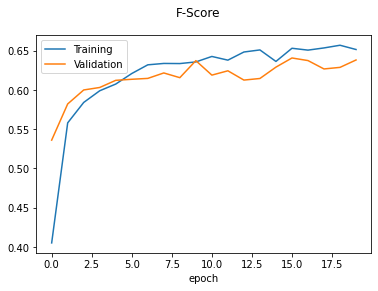

In [ ]:
def plot_metric(metric_train, metric_val, title):
    fig, (ax) = plt.subplots(1, 1)
    fig.suptitle(title)
    ax.set(xlabel='epoch')
    ax.plot(metric_train, label='Training')
    ax.plot(metric_val, label='Validation')
    ax.legend(loc='upper left')
    plt.savefig(title + "_metric.png")

plot_metric(loss_train, loss_val, 'Loss')
plot_metric(acc_train, acc_val, 'Accuracy')
plot_metric(fs_train, fs_val, 'F-Score')

torch.save(loss_train, "loss_train.pkl")
torch.save(loss_val, "loss_val.pkl")
torch.save(acc_train, "acc_train.pkl")
torch.save(acc_val, "acc_val.pkl")
torch.save(fs_train, "fs_train.pkl")
torch.save(fs_val, "fs_val.pkl")

In [ ]:
!zip -r densenet_saved_models.zip models/

  adding: models/ (stored 0%)
  adding: models/densenet_optim_14.pt (deflated 6%)
  adding: models/densenet_model_1.pt (deflated 7%)
  adding: models/densenet_model_14.pt (deflated 7%)
  adding: models/densenet_model_3.pt (deflated 7%)
  adding: models/densenet_model_7.pt (deflated 7%)
  adding: models/densenet_model_2.pt (deflated 7%)
  adding: models/densenet_model_12.pt (deflated 7%)
  adding: models/densenet_optim_16.pt (deflated 6%)
  adding: models/densenet_model_8.pt (deflated 7%)
  adding: models/densenet_optim_2.pt (deflated 6%)
  adding: models/densenet_optim_19.pt (deflated 6%)
  adding: models/densenet_optim_17.pt (deflated 6%)
  adding: models/densenet_optim_8.pt (deflated 5%)
  adding: models/densenet_optim_9.pt (deflated 6%)
  adding: models/densenet_optim_12.pt (deflated 6%)
  adding: models/densenet_model_9.pt (deflated 7%)
  adding: models/densenet_optim_1.pt (deflated 6%)
  adding: models/densenet_optim_13.pt (deflated 6%)
  adding: models/densenet_optim_5.pt (deflat

In [ ]:
!zip -r densenet_saved_output.zip *png *pkl

updating: Accuracy_metric.png (deflated 5%)
updating: F-Score_metric.png (deflated 5%)
updating: Loss_metric.png (deflated 5%)
  adding: acc_train.pkl (deflated 48%)
  adding: acc_val.pkl (deflated 51%)
  adding: fs_train.pkl (deflated 43%)
  adding: fs_val.pkl (deflated 41%)
  adding: loss_train.pkl (deflated 40%)
  adding: loss_val.pkl (deflated 41%)


In [ ]:
!cp *zip '/gdrive/My Drive/Semester 8/CV/snek/models/'
!cp *png '/gdrive/My Drive/Semester 8/CV/snek/models/'